In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
from evojax.util import get_params_format_fn

import os
import time
import numpy as np
import pandas as pd
from scipy import io
import matplotlib.pyplot as plt
import argparse

# choose GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_matmul_precision", "highest")

In [2]:
"""DNN / PINN   """

class PINN(nn.Module):
    """PINNs"""
    n_nodes: int
    t_l: float
    t_u: float
    def setup(self):
        self.layers = [nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       jnp.sin,
                       nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       nn.silu]
        self.last_layer_u = nn.Dense(1, kernel_init = jax.nn.initializers.he_uniform(), use_bias=False)
        self.last_layer_v = nn.Dense(1, kernel_init = jax.nn.initializers.he_uniform(), use_bias=False)

    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        t, x, y = inputs[:,0:1], inputs[:,1:2], inputs[:,2:3]
        def get_uv(t, x, y):
            f = jnp.hstack([t - self.t_l, x, y, t - self.t_u])
            fs = [f]
            for i, lyr in enumerate(self.layers):
                f = lyr(f)
                if (i == 0):
                    f = 2 *jnp.pi *f
                if (i%2 != 0):
                    fs.append(f)
            f = jnp.hstack(fs)
            u, v = self.last_layer_u(f), self.last_layer_v(f)
            return (u, v)

        u, v = get_uv(t, x, y)
        
        # obtain u_t, u_xx, u_yy, v_t, v_xx, v_yy
        def get_uv_dir(get_uv, t, x, y):
            u_t, v_t = jacfwd(get_uv)(t, x, y)
            u_xx, v_xx = jacfwd(jacfwd(get_uv, argnums=1), argnums=1)(t, x, y)
            u_yy, v_yy = jacfwd(jacfwd(get_uv, argnums=2), argnums=2)(t, x, y)
            return u_t, u_xx, u_yy, v_t, v_xx, v_yy
        
        f_dir_vmap = vmap(get_uv_dir, in_axes=(None, 0, 0, 0))
        u_t, u_xx, u_yy, v_t, v_xx, v_yy = f_dir_vmap(get_uv, t, x, y)   
        u_t, u_xx, u_yy = u_t[:,:,0], u_xx[:,:,0,0], u_yy[:,:,0,0]
        v_t, v_xx, v_yy = v_t[:,:,0], v_xx[:,:,0,0], v_yy[:,:,0,0]

        diff_u = u_xx + u_yy
        diff_v = v_xx + v_yy
        
        # PDE: u_t - ep1*(u_xx + u_yy) - b1*(1-u) + c1*u*v*v = 0
        # PDE: v_t - ep2*(v_xx + v_yy) + b2*v - c2*u*v*v = 0
        pde_u = u_t - ep1*(u_xx + u_yy) - b1*(1. - u) + c1*u*v*v
        pde_v = v_t - ep2*(v_xx + v_yy) + b2*v - c2*u*v*v
        
        # obtain BC/IC indices
        ic, bcx, bcy = (t == t_l), (x == x_l), (y == y_l)  # lower x, lower y
        u_xu, v_xu = get_uv(t, jnp.ones_like(t)*x_u, y)
        u_yu, v_yu = get_uv(t, x, jnp.ones_like(t)*y_u)
        pbcx_u, pbcx_v = u_xu - u, v_xu - v
        pbcy_u, pbcy_v = u_yu - u, v_yu - v

        outputs = jnp.hstack([u, v, diff_u, diff_v, pde_u, pde_v, pbcx_u, pbcx_v, pbcy_u, pbcy_v, ic, bcx, bcy])
        return outputs        


class DNN(nn.Module):
    """DNNs"""
    n_nodes: int
    t_l: float
    t_u: float
    def setup(self):
        self.layers = [nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       jnp.sin,
                       nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       nn.silu]
        self.last_layer_u = nn.Dense(1, kernel_init = jax.nn.initializers.he_uniform(), use_bias=False)
        self.last_layer_v = nn.Dense(1, kernel_init = jax.nn.initializers.he_uniform(), use_bias=False)

    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        t, x, y = inputs[:,0:1], inputs[:,1:2], inputs[:,2:3]
        def get_uv(t, x, y):
            f = jnp.hstack([t - self.t_l, x, y, t - self.t_u])
            fs = [f]
            for i, lyr in enumerate(self.layers):
                f = lyr(f)
                if (i == 0):
                    f = 2 *jnp.pi *f
                if (i%2 != 0):
                    fs.append(f)
            f = jnp.hstack(fs)
            u, v = self.last_layer_u(f), self.last_layer_v(f)
            return (u, v)

        u, v = get_uv(t, x, y)

        # obtain u_t, u_xx, u_yy, v_t, v_xx, v_yy
        def get_uv_dir(get_uv, t, x, y):
            u_xx, v_xx = jacfwd(jacfwd(get_uv, argnums=1), argnums=1)(t, x, y)
            u_yy, v_yy = jacfwd(jacfwd(get_uv, argnums=2), argnums=2)(t, x, y)
            return u_xx, u_yy, v_xx, v_yy
        
        f_dir_vmap = vmap(get_uv_dir, in_axes=(None, 0, 0, 0))
        u_xx, u_yy, v_xx, v_yy = f_dir_vmap(get_uv, t, x, y)   
        u_xx, u_yy = u_xx[:,:,0,0], u_yy[:,:,0,0]
        v_xx, v_yy = v_xx[:,:,0,0], v_yy[:,:,0,0]

        diff_u = u_xx + u_yy
        diff_v = v_xx + v_yy

        outputs = jnp.hstack([u, v, diff_u, diff_v])
        return outputs    

In [3]:
def main(ER, ER_xx, weight_ic, weight_bc, max_lr, exponent, max_iter, seed, gpu, T_0, T_1, pred_T):
    
    
    global b1, b2, c1, c2, ep1, ep2
    
    # parameter
    b1, b2 = 40, 100
    c1, c2 = 1000, 1000
    ep1, ep2 = 0.2, 0.1
    
    # read data
    mat_data = io.loadmat('grey_scott.mat')
    
    # spatial resolution
    sim_t = np.repeat(mat_data['t'],200*200).reshape(-1,1)
    sim_x1d, sim_y1d = mat_data['x'].reshape(-1,1), mat_data['y'].reshape(-1,1)
    sim_x, sim_y = np.meshgrid(sim_x1d, sim_y1d, indexing='ij')
    sim_x, sim_y = sim_x.reshape(1,-1), sim_y.reshape(1,-1)
    sim_x, sim_y = np.tile(sim_x,101).reshape(-1,1), np.tile(sim_y,101).reshape(-1,1)
    sim_u, sim_v = mat_data['usol'].reshape(-1,1), mat_data['vsol'].reshape(-1,1)
    
    # subset segment
    data_X, data_Y = np.hstack([sim_t, sim_x, sim_y]), np.hstack([sim_u, sim_v])
    data_X, data_Y = data_X[(data_X[:,0] >= T_0) & (data_X[:,0] <= T_1)], data_Y[(data_X[:,0] >= T_0) & (data_X[:,0] <= T_1)]
    
    global t_l, t_u, x_l, x_u, y_l, y_u

    t_l, t_u = np.min(data_X[:,0]), np.max(data_X[:,0])
    x_l, x_u, y_l, y_u = np.min(data_X[:,1]), np.max(data_X[:,1]), np.min(data_X[:,2]), np.max(data_X[:,2])

    # IC from previous solution
    if len(pred_T) > 0:
        _t = (data_X[:,0] == t_l)
        data_Y[_t] = pred_T
        print ('Use previous PINN solution as IC.')
        
    # split into BC / IC data
    ic = (data_X[:,0] == t_l)
    bc = (data_X[:,1] == x_l) | (data_X[:,2] == y_l)
    data_X_IC, data_Y_IC, data_X_BC, data_Y_BC = data_X[ic], data_Y[ic], data_X[bc], data_Y[bc]
    
    # convert to jnp
    data_X, data_Y = jnp.array(data_X), jnp.array(data_Y)
    data_X_IC, data_Y_IC, data_X_BC, data_Y_BC = jnp.array(data_X_IC), jnp.array(data_Y_IC), jnp.array(data_X_BC), jnp.array(data_Y_BC)
    
    
    # choose seed
    seed = seed
    key, rng = random.split(random.PRNGKey(seed))

    # dummy input
    a = random.normal(key, [1,3])

    # initialization call
    n_nodes = 128
    model, model_0 = PINN(n_nodes, t_l, t_u), DNN(n_nodes, t_l, t_u)
    params = model.init(key, a)
    num_params, format_params_fn = get_params_format_fn(params)
    # print (num_params)

    # flatten initial params
    params = jax.flatten_util.ravel_pytree(params)[0]

    # update u_0
    params_0 = params

    # minibatch (set #sample)
    BS_ALL = 1000
    BS_IC = 50
    BS_BC = 50
    
    n_all, n_ic, n_bc = len(data_X), len(data_X_IC), len(data_X_BC)

    @jit
    def minibatch(key):
        key1, key2, key3, key4, key5, key6 = key
        batch_all = random.choice(key1, n_all, (BS_ALL - BS_IC - BS_BC,))
        batch_ic = random.choice(key2, n_ic, (BS_IC,)) 
        batch_bc = random.choice(key3, n_bc, (BS_BC,)) 
        batch_R = jnp.hstack([random.uniform(key4, shape=(BS_ALL, 1), minval=t_l, maxval=t_u),
                              random.uniform(key5, shape=(BS_ALL, 1), minval=x_l, maxval=x_u),
                              random.uniform(key6, shape=(BS_ALL, 1), minval=y_l, maxval=y_u)])
        batch_X = jnp.vstack([data_X[batch_all], data_X_IC[batch_ic], data_X_BC[batch_bc], batch_R])
        batch_Y = jnp.vstack([data_Y[batch_all], data_Y_IC[batch_ic], data_Y_BC[batch_bc]])
        return (batch_X, batch_Y)   

    # loss function
    def eval_loss(params, params_0, inputs, labels):
        pred = model.apply(format_params_fn(params), inputs)
        u, v, diff_u, diff_v, pde_u, pde_v, pbcx_u, pbcx_v, pbcy_u, pbcy_v, ic, bcx, bcy = jnp.split(pred, 13, axis=1)
        # stable evolution
        pred_0 = model_0.apply(format_params_fn(params_0), inputs)
        u_0, v_0, diff_u_0, diff_v_0 = jnp.split(pred_0, 4, axis=1)
        if (ER > 0):
            pde_u = pde_u + (u - u_0) / ER - ep1*(diff_u - diff_u_0) / ER_xx  # ER @PDE
            pde_v = pde_v + (v - v_0) / ER - ep2*(diff_v - diff_v_0) / ER_xx  # ER @PDE
        pde_loss = jnp.mean(jnp.square(pde_u)) + jnp.mean(jnp.square(pde_v))
        # remove random uniform sample
        u, v, ic = u[:BS_ALL], v[:BS_ALL], ic[:BS_ALL]
        # IC
        ic_e = (labels - jnp.hstack([u, v])) * ic
        ic_loss = jnp.sum(jnp.square(ic_e)) / ic.sum()
        # BC (periodic)
        bcx_e = jnp.hstack([pbcx_u, pbcx_v]) * bcx
        bcy_e = jnp.hstack([pbcy_u, pbcy_v]) * bcy
        bc_loss = jnp.sum(jnp.square(bcx_e)) / bcx.sum() + jnp.sum(jnp.square(bcy_e)) / bcy.sum()
        # mse
        mse = jnp.mean(jnp.square(labels - jnp.hstack([u, v])))
        rl2 = jnp.linalg.norm(labels - jnp.hstack([u, v])) / jnp.linalg.norm(labels)
        loss = pde_loss + weight_ic* ic_loss + weight_bc* bc_loss #+ er_loss
        return loss, (mse, rl2)

    loss_grad = jax.jit(jax.value_and_grad(eval_loss, has_aux=True))

    # weights update
    @jit
    def update(params, params_0, opt_state, key):
        batch_X, batch_Y = minibatch(key)
        (loss, (mse, rl2)), grad = loss_grad(params, params_0, batch_X, batch_Y)
        updates, opt_state = optimizer.update(grad, opt_state)
        params_0 = params # update u_0
        params = optax.apply_updates(params, updates)
        return params, params_0, opt_state, loss, mse, rl2

    # optimizer
    max_iters = max_iter
    max_lr = max_lr
    lr_scheduler = optax.warmup_cosine_decay_schedule(init_value=max_lr, peak_value=max_lr, warmup_steps=0,
                                                    decay_steps=max_iters, end_value=1e-10, exponent=exponent)
    optimizer = optax.adam(learning_rate=lr_scheduler) # Choose the method
    opt_state = optimizer.init(params)

    """Training"""

    # training iteration
    runtime = 0
    train_iters = 0

    #store = []
    store_nnws = []
    store_nnws.append([0, format_params_fn(params)])

    while (train_iters <= max_iters) and (runtime < 10000):
        # mini-batch update
        start = time.time()
        key1, key2, key3, key4, key5, key6, rng = random.split(rng, 7) # update random generator
        params, params_0, opt_state, loss, mse, rl2 = update(params, params_0, opt_state, (key1, key2, key3, key4, key5, key6))
        end = time.time()
        runtime += (end-start)
        # append weights
        if (train_iters % 3000 == 0):
            print ('iter. = %05d,  time = %03ds,  loss = %.2e  |  mse = %.2e,  rl2 = %.2e'%(train_iters, runtime, loss, mse, rl2))
            # store.append([train_iters, runtime, loss, mse, rl2])
            store_nnws.append([runtime, format_params_fn(params)])
        train_iters += 1

    #store = jnp.array(store)

    """PINN solution"""

    # solution
    _t = (data_X[:,0] == t_u)
    inputs, labels = data_X[_t], data_Y[_t]
    pred = model_0.apply(format_params_fn(params), inputs)
    u, v, _, _ = jnp.split(pred, 4, axis=1)
    mse = jnp.mean(jnp.square(labels - jnp.hstack([u, v])))
    rl2 = jnp.linalg.norm(labels - jnp.hstack([u, v])) / jnp.linalg.norm(labels)
    print ('[T = %s - %s] :  MSE = %.2e  RL2 = %.2e'%(t_l, t_u, mse, rl2))

    # save outcome
    save_results = [ER, ER_xx, weight_ic, weight_bc, max_lr, exponent, max_iter, seed, round(runtime)]
    file_path = 'gs_T=0-2s_batch_run_%s.txt'%(gpu)
    with open(file_path, 'a') as f:
        for value in save_results:
            f.write(f"{value},")
        f.write(f"{mse:.2e},")
        f.write(f"{rl2:.2e}\n")

    # info. to pass down to next time window..
    params_T = format_params_fn(params)
    pred_T = jnp.hstack([u, v])
    
    return params_T, pred_T, store_nnws

In [4]:
# # T = 0 - 0.5
# params_T0, pred_T0 = main(ER=0.015, ER_xx=10, weight_ic=5000, weight_bc=1000,
#                           max_lr=2e-3, exponent=1, max_iter=300000, seed=20, gpu=0,
#                           T_0=0.0, T_1=0.5, pred_T=[])

In [5]:
# 5 runs
params_5, store_nnws_5 = {}, {}
for seed in [10, 20, 30, 40, 50]:
    # run main (ER)
    params, pred_T, store_nnws = main(ER=0.015, ER_xx=10, weight_ic=5000, weight_bc=1000,
                                      max_lr=2e-3, exponent=1, max_iter=300000, seed=seed, gpu=0,
                                      T_0=0.0, T_1=0.5, pred_T=[])
    params_5[seed] = params
    store_nnws_5[seed] = store_nnws

iter. = 00000,  time = 006s,  loss = 1.61e+06  |  mse = 8.09e-01,  rl2 = 1.45e+00
iter. = 03000,  time = 012s,  loss = 4.02e+01  |  mse = 4.22e-02,  rl2 = 3.30e-01
iter. = 06000,  time = 019s,  loss = 3.01e+01  |  mse = 4.39e-02,  rl2 = 3.36e-01
iter. = 09000,  time = 026s,  loss = 1.74e+01  |  mse = 4.82e-02,  rl2 = 3.54e-01
iter. = 12000,  time = 032s,  loss = 8.33e+00  |  mse = 4.87e-02,  rl2 = 3.59e-01
iter. = 15000,  time = 039s,  loss = 4.66e+01  |  mse = 3.84e-02,  rl2 = 3.15e-01
iter. = 18000,  time = 045s,  loss = 2.06e+01  |  mse = 4.38e-02,  rl2 = 3.38e-01
iter. = 21000,  time = 052s,  loss = 9.26e+00  |  mse = 4.92e-02,  rl2 = 3.62e-01
iter. = 24000,  time = 059s,  loss = 1.75e+02  |  mse = 3.95e-02,  rl2 = 3.16e-01
iter. = 27000,  time = 066s,  loss = 4.49e+01  |  mse = 3.60e-02,  rl2 = 3.06e-01
iter. = 30000,  time = 072s,  loss = 2.78e+01  |  mse = 4.05e-02,  rl2 = 3.22e-01
iter. = 33000,  time = 079s,  loss = 1.04e+01  |  mse = 4.99e-02,  rl2 = 3.63e-01
iter. = 36000,  

In [24]:
# 5 runs (ref)
ref_params_5, ref_store_nnws_5 = {}, {}
for seed in [10, 20, 30, 40, 50]:
    # run main (ER)
    params, pred_T, store_nnws = main(ER=0, ER_xx=10, weight_ic=5000, weight_bc=1000,
                                      max_lr=2e-3, exponent=1, max_iter=300000, seed=seed, gpu=0,
                                      T_0=0.0, T_1=0.5, pred_T=[])
    ref_params_5[seed] = params
    ref_store_nnws_5[seed] = store_nnws

iter. = 00000,  time = 004s,  loss = 1.61e+06  |  mse = 8.09e-01,  rl2 = 1.45e+00
iter. = 03000,  time = 010s,  loss = 4.15e+01  |  mse = 3.44e-02,  rl2 = 2.98e-01
iter. = 06000,  time = 016s,  loss = 3.18e+01  |  mse = 3.14e-02,  rl2 = 2.84e-01
iter. = 09000,  time = 021s,  loss = 1.94e+01  |  mse = 3.00e-02,  rl2 = 2.80e-01
iter. = 12000,  time = 027s,  loss = 1.23e+01  |  mse = 3.65e-02,  rl2 = 3.11e-01
iter. = 15000,  time = 033s,  loss = 3.26e+01  |  mse = 4.65e-02,  rl2 = 3.46e-01
iter. = 18000,  time = 039s,  loss = 3.05e+01  |  mse = 4.04e-02,  rl2 = 3.25e-01
iter. = 21000,  time = 044s,  loss = 5.23e+00  |  mse = 4.97e-02,  rl2 = 3.63e-01
iter. = 24000,  time = 050s,  loss = 1.48e+00  |  mse = 4.23e-02,  rl2 = 3.27e-01
iter. = 27000,  time = 056s,  loss = 2.10e+00  |  mse = 4.61e-02,  rl2 = 3.46e-01
iter. = 30000,  time = 062s,  loss = 6.58e-01  |  mse = 4.30e-02,  rl2 = 3.32e-01
iter. = 33000,  time = 067s,  loss = 2.34e+00  |  mse = 4.96e-02,  rl2 = 3.62e-01
iter. = 36000,  

In [25]:
import pickle
# save all weight
pickle.dump(params_5, open('batch5_final_gs', 'wb'))
pickle.dump(store_nnws_5, open('batch5_hist_gs', 'wb'))
pickle.dump(ref_params_5, open('batch5_final_gs-ref', 'wb'))
pickle.dump(ref_store_nnws_5, open('batch5_hist_gs-ref', 'wb'))

In [15]:
# read data
mat_data = io.loadmat('grey_scott.mat')
    
# spatial resolution
sim_t = np.repeat(mat_data['t'],200*200).reshape(-1,1)
sim_x1d, sim_y1d = mat_data['x'].reshape(-1,1), mat_data['y'].reshape(-1,1)
sim_x, sim_y = np.meshgrid(sim_x1d, sim_y1d, indexing='ij')
sim_x, sim_y = sim_x.reshape(1,-1), sim_y.reshape(1,-1)
sim_x, sim_y = np.tile(sim_x,101).reshape(-1,1), np.tile(sim_y,101).reshape(-1,1)
sim_u, sim_v = mat_data['usol'].reshape(-1,1), mat_data['vsol'].reshape(-1,1)

T_0, T_1 = [0, 0.5]
# convert to jnp
data_X, data_Y = np.hstack([sim_t, sim_x, sim_y]), np.hstack([sim_u, sim_v])
data_X, data_Y = data_X[(data_X[:,0] >= T_0) & (data_X[:,0] <= T_1)], data_Y[(data_X[:,0] >= T_0) & (data_X[:,0] <= T_1)]
data_X, data_Y = jnp.array(data_X), jnp.array(data_Y)

# model
model_0 = DNN(128, T_0, T_1)

[T = 0 - 0.5s] :  MSE = 2.65e-07  RL2 = 8.42e-04


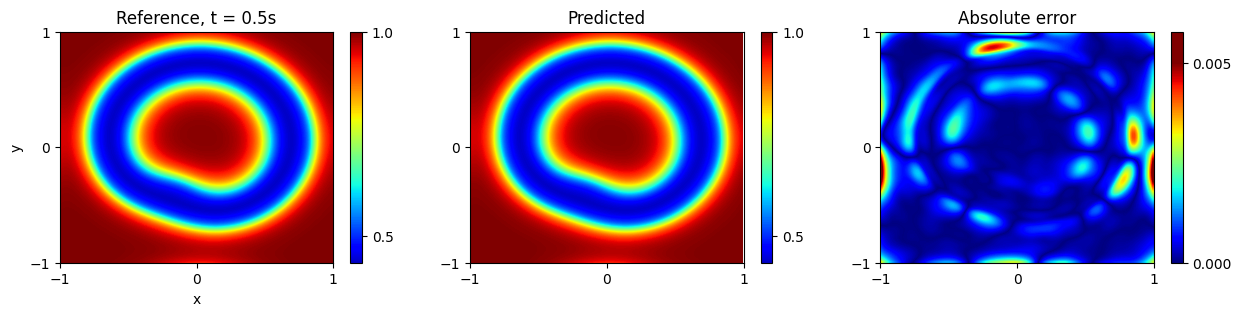

In [90]:
# PINN (final)
params = params_5[20]

# prediction by segment
ts = jnp.unique(data_X[:,0])
uv_list = []
for t in ts:
    _t = (data_X[:,0] == t)
    inputs, labels = data_X[_t], data_Y[_t]
    pred = model_0.apply(params, inputs)
    u, v, _, _ = jnp.split(pred, 4, axis=1)
    uv_list.append(jnp.hstack([u, v]))
uv = jnp.concatenate(uv_list)
#print (uv.shape)

# error
mse = jnp.mean(jnp.square(data_Y - uv))
rl2 = jnp.linalg.norm(data_Y - uv) / jnp.linalg.norm(data_Y)
print ('[T = 0 - 0.5s] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2))

# time stmap (t=0.5)
T_P = 0.5
_t = (data_X[:,0] == T_P).flatten()

pd_uv, gt_uv = jnp.sqrt(uv[:,0]**2 + uv[:,1]**2), jnp.sqrt(data_Y[:,0]**2 + data_Y[:,1]**2)

# plot predicted velocity
fig = plt.figure(figsize=(15, 3))
# low fi
con_lv = 501
ext = [-1, 1, -1, 1]
# PINN
ax1 = fig.add_subplot(1,3,1)
clv = plt.contourf(gt_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0.4, vmax=1.);
plt.colorbar(ticks=[0.5, 1]) ;plt.title('Reference, t = %ss'%T_P); plt.xlabel('x'); plt.ylabel('y'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]);
ax1 = fig.add_subplot(1,3,2)
plt.contourf(pd_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0.4, vmax=1.);
plt.colorbar(ticks=[0.5, 1]); plt.title('Predicted'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]); 
ax1 = fig.add_subplot(1,3,3)
plt.contourf(abs(pd_uv[_t] - gt_uv[_t]).reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0, vmax=0.005);
plt.colorbar(ticks=[0, 0.005]); plt.title('Absolute error'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]);

    [T = 0 - 0.5s] :  MSE = 2.65e-07  RL2 = 8.42e-04

In [23]:
# average of 5
rl2s = []
for seed in [10, 20, 30, 40, 50]:
    params = params_5[seed]
    # prediction by segment
    ts = jnp.unique(data_X[:,0])
    uv_list = []
    for t in ts:
        _t = (data_X[:,0] == t)
        inputs, labels = data_X[_t], data_Y[_t]
        pred = model_0.apply(params, inputs)
        u, v, _, _ = jnp.split(pred, 4, axis=1)
        uv_list.append(jnp.hstack([u, v]))
    uv = jnp.concatenate(uv_list)
    # prediction errors
    mse = jnp.mean(jnp.square(data_Y - uv))
    rl2 = jnp.linalg.norm(data_Y - uv) / jnp.linalg.norm(data_Y)
    print ('[T = 0 - 0.5s] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2))
    rl2s.append(rl2)
rl2s = np.array(rl2s)
print ('[T = 0 - 0.5s] :  RL2 best = %.2e  ave = %.2e'%(rl2s.min(), rl2s.mean()))

[T = 0 - 0.5s] :  MSE = 7.37e-07  RL2 = 1.40e-03
[T = 0 - 0.5s] :  MSE = 2.65e-07  RL2 = 8.42e-04
[T = 0 - 0.5s] :  MSE = 4.13e-07  RL2 = 1.05e-03
[T = 0 - 0.5s] :  MSE = 1.20e-06  RL2 = 1.79e-03
[T = 0 - 0.5s] :  MSE = 1.30e-06  RL2 = 1.86e-03
[T = 0 - 0.5s] :  RL2 best = 8.42e-04  ave = 1.39e-03


In [26]:
# convergence
p_time2sol_5 = {}
for seed in [10, 20, 30, 40, 50]:
    store_nnws = store_nnws_5[seed]
    p_time2sol = []
    for i in range(0, len(store_nnws), 5):
        runtime, params = store_nnws[i]
        # prediction by segment
        ts = jnp.unique(data_X[:,0])
        uv_list = []
        for t in ts:
            _t = (data_X[:,0] == t)
            inputs, labels = data_X[_t], data_Y[_t]
            pred = model_0.apply(params, inputs)
            u, v, _, _ = jnp.split(pred, 4, axis=1)
            uv_list.append(jnp.hstack([u, v]))
        uv = jnp.concatenate(uv_list)
        # prediction errors
        mse = jnp.mean(jnp.square(data_Y - uv))
        rl2 = jnp.linalg.norm(data_Y - uv) / jnp.linalg.norm(data_Y)
        #print ('[T = 0 - 0.5s] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2)) 
        p_time2sol.append([runtime, rl2])
    runtime, params = store_nnws[-1]
    # prediction by segment
    ts = jnp.unique(data_X[:,0])
    uv_list = []
    for t in ts:
        _t = (data_X[:,0] == t)
        inputs, labels = data_X[_t], data_Y[_t]
        pred = model_0.apply(params, inputs)
        u, v, _, _ = jnp.split(pred, 4, axis=1)
        uv_list.append(jnp.hstack([u, v]))
    uv = jnp.concatenate(uv_list)
    # prediction errors
    mse = jnp.mean(jnp.square(data_Y - uv))
    rl2 = jnp.linalg.norm(data_Y - uv) / jnp.linalg.norm(data_Y)
    #print ('[T = 0 - 0.5s] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2))
    p_time2sol.append([runtime, rl2])    
    print ('[time = %03ds] :  RL2 = %.2e'%(runtime, rl2))    
    p_time2sol = np.array(p_time2sol)
    p_time2sol_5[seed] = p_time2sol

[time = 678s] :  RL2 = 1.40e-03
[time = 678s] :  RL2 = 8.42e-04
[time = 679s] :  RL2 = 1.05e-03
[time = 678s] :  RL2 = 1.79e-03
[time = 679s] :  RL2 = 1.86e-03


In [27]:
# convergence (ref)
ref_p_time2sol_5 = {}
for seed in [10, 20, 30, 40, 50]:
    store_nnws = ref_store_nnws_5[seed]
    p_time2sol = []
    for i in range(0, len(store_nnws), 5):
        runtime, params = store_nnws[i]
        # prediction by segment
        ts = jnp.unique(data_X[:,0])
        uv_list = []
        for t in ts:
            _t = (data_X[:,0] == t)
            inputs, labels = data_X[_t], data_Y[_t]
            pred = model_0.apply(params, inputs)
            u, v, _, _ = jnp.split(pred, 4, axis=1)
            uv_list.append(jnp.hstack([u, v]))
        uv = jnp.concatenate(uv_list)
        # prediction errors
        mse = jnp.mean(jnp.square(data_Y - uv))
        rl2 = jnp.linalg.norm(data_Y - uv) / jnp.linalg.norm(data_Y)
        #print ('[T = 0 - 0.5s] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2)) 
        p_time2sol.append([runtime, rl2])
    runtime, params = store_nnws[-1]
    # prediction by segment
    ts = jnp.unique(data_X[:,0])
    uv_list = []
    for t in ts:
        _t = (data_X[:,0] == t)
        inputs, labels = data_X[_t], data_Y[_t]
        pred = model_0.apply(params, inputs)
        u, v, _, _ = jnp.split(pred, 4, axis=1)
        uv_list.append(jnp.hstack([u, v]))
    uv = jnp.concatenate(uv_list)
    # prediction errors
    mse = jnp.mean(jnp.square(data_Y - uv))
    rl2 = jnp.linalg.norm(data_Y - uv) / jnp.linalg.norm(data_Y)
    #print ('[T = 0 - 0.5s] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2))
    p_time2sol.append([runtime, rl2])    
    print ('[time = %03ds] :  RL2 = %.2e'%(runtime, rl2))    
    p_time2sol = np.array(p_time2sol)
    ref_p_time2sol_5[seed] = p_time2sol

[time = 588s] :  RL2 = 3.53e-01
[time = 591s] :  RL2 = 3.54e-01
[time = 591s] :  RL2 = 3.53e-01
[time = 591s] :  RL2 = 3.51e-01
[time = 591s] :  RL2 = 3.53e-01


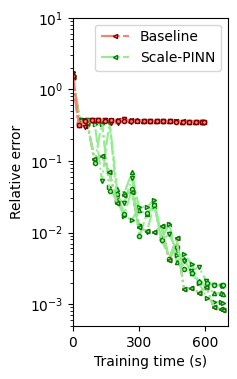

In [89]:
fig = plt.figure(figsize=(2, 4))
makers = ['^', '<', '>', 'v', 'o']
for i, seed in enumerate([10, 20, 30, 40, 50]):
    p_time2sol = p_time2sol_5[seed]
    plt.plot(p_time2sol[:,0], p_time2sol[:,1], c='lightgreen', markeredgecolor='green', marker=makers[i], markersize=3, linestyle='-.');
p_time2sol = p_time2sol_5[20]
plt.plot(p_time2sol[:,0], p_time2sol[:,1], c='salmon', markeredgecolor='maroon', marker=makers[1], markersize=3, linestyle='-.', label='Baseline');
plt.plot(p_time2sol[:,0], p_time2sol[:,1], c='lightgreen', markeredgecolor='green', marker=makers[1], markersize=3, linestyle='-.', label='Scale-PINN');
for i, seed in enumerate([10, 20, 30, 40, 50]):
    p_time2sol = ref_p_time2sol_5[seed]
    plt.plot(p_time2sol[:,0], p_time2sol[:,1], c='salmon', markeredgecolor='maroon', marker=makers[i], markersize=3, linestyle='-.');
plt.xlabel('Training time (s)'); plt.ylabel('Relative error'); plt.yscale('log'); plt.ylim(5e-4, 10); plt.xlim(-0.5, 700);
plt.xticks([0, 300, 600]); plt.legend();

[T = 0 - 0.5s] :  MSE = 2.65e-07  RL2 = 8.42e-04


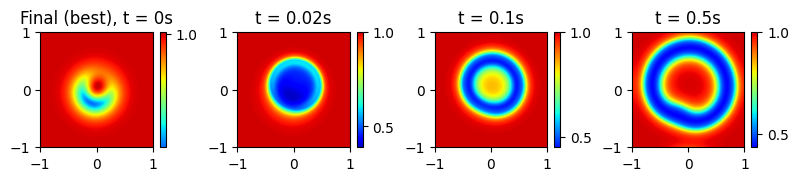

In [85]:
# PINN (final)
params = params_5[20]

# prediction by segment
ts = jnp.unique(data_X[:,0])
uv_list = []
for t in ts:
    _t = (data_X[:,0] == t)
    inputs, labels = data_X[_t], data_Y[_t]
    pred = model_0.apply(params, inputs)
    u, v, _, _ = jnp.split(pred, 4, axis=1)
    uv_list.append(jnp.hstack([u, v]))
uv = jnp.concatenate(uv_list)
#print (uv.shape)

# error
mse = jnp.mean(jnp.square(data_Y - uv))
rl2 = jnp.linalg.norm(data_Y - uv) / jnp.linalg.norm(data_Y)
print ('[T = 0 - 0.5s] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2))

# plot
fig = plt.figure(figsize=(9.45, 1.5))
plt.subplots_adjust(wspace=0.4)
# low fi
con_lv = 501
ext = [-1, 1, -1, 1]
# PINN
ax1 = fig.add_subplot(1,4,1)
# time stmap (t=0.5)
T_P = 0.0
_t = (data_X[:,0] == T_P).flatten()
pd_uv, gt_uv = jnp.sqrt(uv[:,0]**2 + uv[:,1]**2), jnp.sqrt(data_Y[:,0]**2 + data_Y[:,1]**2)
plt.contourf(pd_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0.35, vmax=1.05);
plt.colorbar(ticks=[0.5, 1]); plt.title('Final (best), t = 0s'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]); 
ax1 = fig.add_subplot(1,4,2)
# time stmap (t=0.5)
T_P = 0.02
_t = (data_X[:,0] == T_P).flatten()
pd_uv, gt_uv = jnp.sqrt(uv[:,0]**2 + uv[:,1]**2), jnp.sqrt(data_Y[:,0]**2 + data_Y[:,1]**2)
plt.contourf(pd_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0.35, vmax=1.05);
plt.colorbar(ticks=[0.5, 1]); plt.title('t = 0.02s'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]); 
ax1 = fig.add_subplot(1,4,3)
# time stmap (t=0.5)
T_P = 0.1
_t = (data_X[:,0] == T_P).flatten()
pd_uv, gt_uv = jnp.sqrt(uv[:,0]**2 + uv[:,1]**2), jnp.sqrt(data_Y[:,0]**2 + data_Y[:,1]**2)
plt.contourf(pd_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0.35, vmax=1.05);
plt.colorbar(ticks=[0.5, 1]); plt.title('t = 0.1s'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]); 
ax1 = fig.add_subplot(1,4,4)
# time stmap (t=0.5)
T_P = 0.5
_t = (data_X[:,0] == T_P).flatten()
pd_uv, gt_uv = jnp.sqrt(uv[:,0]**2 + uv[:,1]**2), jnp.sqrt(data_Y[:,0]**2 + data_Y[:,1]**2)
plt.contourf(pd_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0.35, vmax=1.05);
plt.colorbar(ticks=[0.5, 1]); plt.title('t = 0.5s'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]); 

[T = 0 - 0.5s] :  MSE = 4.68e-02  RL2 = 3.54e-01


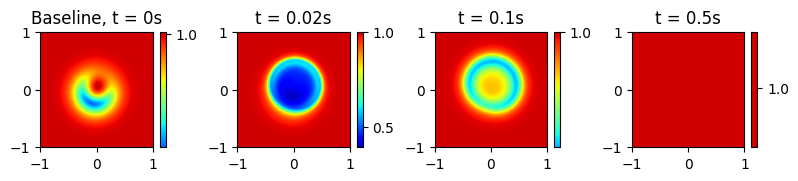

In [86]:
# PINN (ref)
params = ref_params_5[20]

# prediction by segment
ts = jnp.unique(data_X[:,0])
uv_list = []
for t in ts:
    _t = (data_X[:,0] == t)
    inputs, labels = data_X[_t], data_Y[_t]
    pred = model_0.apply(params, inputs)
    u, v, _, _ = jnp.split(pred, 4, axis=1)
    uv_list.append(jnp.hstack([u, v]))
uv = jnp.concatenate(uv_list)
#print (uv.shape)

# error
mse = jnp.mean(jnp.square(data_Y - uv))
rl2 = jnp.linalg.norm(data_Y - uv) / jnp.linalg.norm(data_Y)
print ('[T = 0 - 0.5s] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2))

# plot
fig = plt.figure(figsize=(9.45, 1.5))
plt.subplots_adjust(wspace=0.4)
# low fi
con_lv = 501
ext = [-1, 1, -1, 1]
# PINN
ax1 = fig.add_subplot(1,4,1)
# time stmap (t=0.5)
T_P = 0.0
_t = (data_X[:,0] == T_P).flatten()
pd_uv, gt_uv = jnp.sqrt(uv[:,0]**2 + uv[:,1]**2), jnp.sqrt(data_Y[:,0]**2 + data_Y[:,1]**2)
plt.contourf(pd_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0.35, vmax=1.05);
plt.colorbar(ticks=[0.5, 1]); plt.title('Baseline, t = 0s'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]); 
ax1 = fig.add_subplot(1,4,2)
# time stmap (t=0.5)
T_P = 0.02
_t = (data_X[:,0] == T_P).flatten()
pd_uv, gt_uv = jnp.sqrt(uv[:,0]**2 + uv[:,1]**2), jnp.sqrt(data_Y[:,0]**2 + data_Y[:,1]**2)
plt.contourf(pd_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0.35, vmax=1.05);
plt.colorbar(ticks=[0.5, 1]); plt.title('t = 0.02s'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]); 
ax1 = fig.add_subplot(1,4,3)
# time stmap (t=0.5)
T_P = 0.1
_t = (data_X[:,0] == T_P).flatten()
pd_uv, gt_uv = jnp.sqrt(uv[:,0]**2 + uv[:,1]**2), jnp.sqrt(data_Y[:,0]**2 + data_Y[:,1]**2)
plt.contourf(pd_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0.35, vmax=1.05);
plt.colorbar(ticks=[0.5, 1]); plt.title('t = 0.1s'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]); 
ax1 = fig.add_subplot(1,4,4)
# time stmap (t=0.5)
T_P = 0.5
_t = (data_X[:,0] == T_P).flatten()
pd_uv, gt_uv = jnp.sqrt(uv[:,0]**2 + uv[:,1]**2), jnp.sqrt(data_Y[:,0]**2 + data_Y[:,1]**2)
plt.contourf(pd_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0.35, vmax=1.05);
plt.colorbar(ticks=[0.5, 1]); plt.title('t = 0.5s'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]); 

[T = 0 - 0.5s] :  MSE = 8.39e-01  RL2 = 1.50e+00


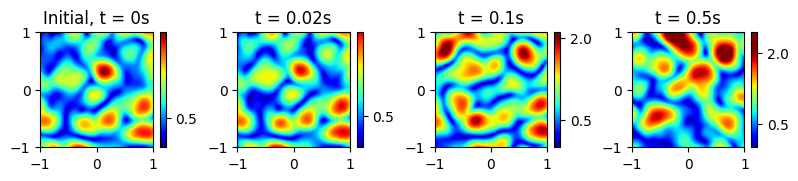

In [88]:
# PINN (initial)
store_nnws = store_nnws_5[20]
runtime, params = store_nnws[0]

# prediction by segment
ts = jnp.unique(data_X[:,0])
uv_list = []
for t in ts:
    _t = (data_X[:,0] == t)
    inputs, labels = data_X[_t], data_Y[_t]
    pred = model_0.apply(params, inputs)
    u, v, _, _ = jnp.split(pred, 4, axis=1)
    uv_list.append(jnp.hstack([u, v]))
uv = jnp.concatenate(uv_list)
#print (uv.shape)

# error
mse = jnp.mean(jnp.square(data_Y - uv))
rl2 = jnp.linalg.norm(data_Y - uv) / jnp.linalg.norm(data_Y)
print ('[T = 0 - 0.5s] :  MSE = %.2e  RL2 = %.2e'%(mse, rl2))

# plot
fig = plt.figure(figsize=(9.45, 1.5))
plt.subplots_adjust(wspace=0.4)
# low fi
con_lv = 501
ext = [-1, 1, -1, 1]
# PINN
ax1 = fig.add_subplot(1,4,1)
# time stmap (t=0.5)
T_P = 0.0
_t = (data_X[:,0] == T_P).flatten()
pd_uv, gt_uv = jnp.sqrt(uv[:,0]**2 + uv[:,1]**2), jnp.sqrt(data_Y[:,0]**2 + data_Y[:,1]**2)
plt.contourf(pd_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0, vmax=2);
plt.colorbar(ticks=[0.5, 2]); plt.title('Initial, t = 0s'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]); 
ax1 = fig.add_subplot(1,4,2)
# time stmap (t=0.5)
T_P = 0.02
_t = (data_X[:,0] == T_P).flatten()
pd_uv, gt_uv = jnp.sqrt(uv[:,0]**2 + uv[:,1]**2), jnp.sqrt(data_Y[:,0]**2 + data_Y[:,1]**2)
plt.contourf(pd_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0., vmax=2);
plt.colorbar(ticks=[0.5, 2]); plt.title('t = 0.02s'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]); 
ax1 = fig.add_subplot(1,4,3)
# time stmap (t=0.5)
T_P = 0.1
_t = (data_X[:,0] == T_P).flatten()
pd_uv, gt_uv = jnp.sqrt(uv[:,0]**2 + uv[:,1]**2), jnp.sqrt(data_Y[:,0]**2 + data_Y[:,1]**2)
plt.contourf(pd_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0., vmax=2);
plt.colorbar(ticks=[0.5, 2]); plt.title('t = 0.1s'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]); 
ax1 = fig.add_subplot(1,4,4)
# time stmap (t=0.5)
T_P = 0.5
_t = (data_X[:,0] == T_P).flatten()
pd_uv, gt_uv = jnp.sqrt(uv[:,0]**2 + uv[:,1]**2), jnp.sqrt(data_Y[:,0]**2 + data_Y[:,1]**2)
plt.contourf(pd_uv[_t].reshape(-1, 200).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0., vmax=2);
plt.colorbar(ticks=[0.5, 2]); plt.title('t = 0.5s'); plt.yticks([-1, 0 ,1]); plt.xticks([-1, 0 ,1]); 